# 2024 最新cninfo报告下载与词频分析！

### 安装需要的库

In [ ]:
%conda install -c conda-forge pandas requests tqdm selenium==3.141.0 urllib3==1.26.2 textract matplotlib -y

### 1.自行准备需要分析的企业代码，此处以所有上市公司为例（来自CNRDS）


In [ ]:
import pandas as pd
import os

# 确保输出目录存在
os.makedirs('output', exist_ok=True)

# 读取CSV文件，并进行转换和筛选
df = pd.read_csv('data/公司基本信息.csv', usecols=['Scode'])\
    .rename(columns={'Scode': 'code'})\
    .astype({'code': str})\
    .apply(lambda x: x.str.zfill(6))

# 可选：若作为测试，随机抽样5个公司
# df = df.sample(5)

df.head()

### 2.通过抓取企业信息

现在我们已经有了所有需要分析的公司代码，为了获得企业的公告页面地址，需要先从接口爬取org_id

In [ ]:
import requests

def get_org_id(code):
    """
    根据公司代码获取org_id。
    
    参数:
    - code: 公司代码
    
    返回:
    - 如果成功，返回一个包含orgId, pinyin, zwjc, category的元组。
    - 如果失败，返回四个None。
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    }
    org_id_url = "http://www.cninfo.com.cn/new/information/topSearch/query"

    params = {
        "keyWord": code,
        "maxNum": "10",
    }

    try:
        response = requests.post(url=org_id_url, data=params, headers=headers)
        response.raise_for_status()  # 若不是200状态，抛出异常
        org_id_response = response.json()
        if org_id_response:  # 若有结果
            data = org_id_response[0]  # 取第一个结果即可
            return data['orgId'], data['pinyin'], data['zwjc'], data['category']
        else:  # 若没有结果
            print(f"No matching company found for {code}")
            return None, None, None, None
    except requests.exceptions.RequestException as e:  # 捕获requests产生的异常
        print(f"Error fetching org ID for {code}: {e}")
        return None, None, None, None                  # 如果没有符合条件的公司信息，返回None
    
get_org_id('603871')  # 测试

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas() # 给任务加上进度条，进度条在动我就能摸鱼

df['org_id'], df['pinyin'], df['zwjc'], df['category'] = zip(*df['code'].progress_apply(get_org_id))

# 拼接最新公告页面链接
# example: http://www.cninfo.com.cn/new/disclosure/stock?stockCode=001368&orgId=9900046506#latestAnnouncement
df["latest_announcement_url"] = "http://www.cninfo.com.cn/new/disclosure/stock?stockCode=" + df["code"] + "&orgId=" + df["org_id"].astype(str) + "#latestAnnouncement"

df.to_csv('output/01_cninfo_pages.csv', index=False)
df.head()

In [ ]:
# 对code=603871的行重新运行
df.loc[df['code'] == '603871', 'org_id'] = '9900034449'
df.loc[df['code'] == '603871', 'pinyin'] = 'jygj'
df.loc[df['code'] == '603871', 'zwjc'] = '嘉友国际'
df.loc[df['code'] == '603871', 'category'] = 'A股'
df.loc[df['code'] == '603871', 'latest_announcement_url'] = "http://www.cninfo.com.cn/new/disclosure/stock?stockCode=603871&orgId=9900034449#latestAnnouncement"

df.isnull().sum()

In [ ]:
# 剩余25个经检验是没救了直接删掉
df = df[df['org_id'].notnull()]
df.to_csv('output/01_cninfo_pages.csv', index=False)
df.shape

### 3.获取各公司页面下所有报告信息、下载地址

现在我们已经有了每个企业公告页面的链接，具体公告的地址在这些页面下，我们需要进一步爬取每个公告的地址；

注意：direct_link是PDF地址，如果该地址404，说明这则公告是html，后续处理需要回退到href，将其保存为txt文件；

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def fetch_url(code, url, driver):
    """
    使用Selenium访问指定的URL并抓取公告详细信息。
    
    参数:
    - code: 公司代码。
    - url: 访问的页面URL。
    - driver: Selenium WebDriver实例。
    
    返回:
    - announcements: 包含所有公告详细信息的列表。
    """
    driver.get(url)
    
    # 等待页面加载完成
    try:
        items = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "total-box"))
        ).text
    except:
        items = '共0条'
        return [] # 没有公告信息，直接放回
    items = int(items[1:-1].strip())                    # 从"共xxx条"中提取数字
    pages = items // 30 + (1 if items % 30 > 0 else 0)  # 计算页数
    
    announcements = []
    for page in range(1, pages + 1):
        # 处理机制1，针对少数公告无法加载的情况,用于最后对异常公告的处理
        # 等待页面所有公告加载完成
        # try:
        #     WebDriverWait(driver, 10).until(
        #         EC.presence_of_all_elements_located((By.CLASS_NAME, "el-table__row"))
        #     )
        # except:
        #     # 实在加载不出来，尝试点击下一页
        #     try:
        #         # 等待下一页按钮可点击
        #         WebDriverWait(driver, 10).until(
        #             EC.element_to_be_clickable((By.CLASS_NAME, "btn-next"))
        #         ).click()
        #     except:
        #     # 若下一页一直无法点击，则走出循环
        #         continue

        # 处理机制2，针对大多数公告的情况
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, "el-table__row"))
        )

        items = driver.find_elements(By.CLASS_NAME, "el-table__row")
        for i in items:
            try:
                href = i.find_element(By.CLASS_NAME, "ahover").get_attribute("href")
                time = href.split("=")[-1][:10]
                title = i.find_element(By.CLASS_NAME, "r-title").text
                file_name = i.find_element(By.CLASS_NAME, "ahover").get_attribute("data-id")
                direct_link = f"https://static.cninfo.com.cn/finalpage/{time}/{file_name}.PDF"
                announcements.append((code, time, title, file_name, href, direct_link))
            except:
                continue
        if page < pages:
            try:
                # 等待下一页按钮可点击
                WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CLASS_NAME, "btn-next"))
                ).click()
            except:
                continue
    return announcements


In [ ]:
import pandas as pd
from selenium import webdriver

def fetch_and_save_announcements(code, url):
    """
    对指定的公司代码使用Selenium抓取并保存公告信息。
    
    参数:
    - code: 公司代码。
    - url: 公告页面URL。
    - driver_path: WebDriver路径。
    """
    options = webdriver.ChromeOptions()
    # options.add_argument('--headless')
    # options.add_argument('--disable-gpu')
    with webdriver.Chrome(options=options) as driver:
        announcements = fetch_url(code, url, driver)  # 调用之前定义的fetch_url函数
        if announcements:  # 如果有公告信息
            announcements_df = pd.DataFrame(announcements, columns=["code", "time", "title", "file_name", "href", "direct_link"])
            announcements_df.drop_duplicates(subset=["file_name"], inplace=True)
            announcements_df.to_csv(f"output/02_announcements_lists/{code}.csv", index=False)

In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

df = pd.read_csv("output/01_cninfo_pages.csv")
df = df.sample(frac=1).reset_index(drop=True) # 打乱，以使时间预估更准确
os.makedirs("output/02_announcements_lists", exist_ok=True)

# 查找已完成的code
completed_codes = [int(file_name.split(".")[0]) for file_name in os.listdir("output/02_announcements_lists") if file_name.endswith(".csv")]

# 并行处理
with ThreadPoolExecutor(max_workers=8) as executor:
    future_to_code = {executor.submit(fetch_and_save_announcements, row["code"], row["latest_announcement_url"]): row["code"] for index, row in df.iterrows() if int(row["code"]) not in completed_codes}
    
    for future in tqdm(as_completed(future_to_code), total=len(future_to_code)):
        code = future_to_code[future]
        try:
            future.result()
        except Exception as e:
            print(f"Error fetching data for code {code}: {e}")

In [ ]:
import pandas as pd
import os

company_list = [file for file in os.listdir("output/02_announcements_lists") if file.endswith(".csv")]

dataframes = []

for file in company_list:
    df_temp = pd.read_csv(f"output/02_announcements_lists/{file}")
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

df.sort_values(by=['code', 'time'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv("output/02_announcements_list.csv", index=False)
df.head()


### 4.下载报告进入downloads文件夹

In [ ]:
# 数据预处理
import pandas as pd

df = pd.read_csv('output/02_announcements_list.csv')
df['year'] = df['time'].apply(lambda x: x[:4])
# 确保'year'列只包含四位数字
df = df[df['year'].str.isdigit() & (df['year'].apply(lambda x: len(x) == 4))]
df['year'] = df['year'].astype(int)
df.head()


In [ ]:
import random
# 时间段选择
df = df[(df['year'] >= 2014) & (df['year'] <= 2023)]
# 公司抽样 100个
company_sample = random.sample(df['code'].unique().tolist(), 100)
df = df[df['code'].isin(company_sample)]
df.reset_index(drop=True, inplace=True)
df.to_csv('output/03_sample.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_csv('output/03_sample.csv')
df.head()

,code,time,title,file_name,href,direct_link,year
0,20,2014-01-18,深华发Ａ：董事会2014年第一次临时会议决议公告,63496962,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
1,20,2014-01-25,深华发Ａ：2013年年度业绩预告公告,63523219,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
2,20,2014-01-25,深华发Ａ：关于全资子公司完成工商变更登记的公告,63523218,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
3,20,2014-02-15,深华发Ａ：关于公司及相关主体承诺履行情况的公告,63572860,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-02...,2014
4,20,2014-03-17,深华发Ａ：澄清公告,63679511,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-03...,2014


In [2]:
import requests
import os
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def is_downloaded(code, file_name):
    """
    测试文件（PDF或HTML）是否已经下载
    """
    pdf_path = f"output/04_announcements/{code}/{file_name}.pdf"
    html_path = f"output/04_announcements/{code}/{file_name}.html"
    return os.path.exists(pdf_path) or os.path.exists(html_path)

def is_remote_exist(file_name, direct_link):
    """
    测试direct_link能否返回文件
    """
    try:
        response = requests.head(direct_link, timeout=10)
        return response.status_code == 200
    except requests.RequestException as e:
        logging.error(f"查询 {file_name}.pdf 时发生错误: {e}")
        return False
    
def save_pdf(code, file_name, direct_link):
    file_path = os.path.abspath(os.path.join("output/04_announcements", str(code), f"{file_name}.pdf"))
    try:
        response = requests.get(direct_link, timeout=10)
        if response.status_code == 200:
            os.makedirs(os.path.dirname(file_path), exist_ok=True)
            with open(file_path, "wb") as f:
                f.write(response.content)
        else:
            logging.error(f"{file_name}.pdf 下载失败，HTTP 状态码: {response.status_code}")
    except requests.RequestException as e:
        logging.error(f"保存 {file_name}.pdf 时发生错误: {e}")

def save_html(code, file_name, href):
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    try:
        with webdriver.Chrome(options=options) as driver:
            driver.get(href)
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CLASS_NAME, "page-detail-article"))
            )
            content = driver.find_element(By.CLASS_NAME, "page-detail-article").get_attribute("outerHTML")
            with open(f"output/04_announcements/{code}/{file_name}.html", "w", encoding="utf-8") as f:
                f.write(content)
    except Exception as e:
        logging.error(f"保存 {file_name}.html 时发生错误: {e}")

def download(row):
    """
    下载逻辑实现
    """
    code, file_name, href, direct_link = row['code'], row['file_name'], row['href'], row['direct_link']
    if not is_downloaded(code, file_name):
        os.makedirs(f"output/04_announcements/{code}", exist_ok=True)
    else:
        return
    # 远程pdf存在则下载
    if is_remote_exist(file_name, direct_link):
        save_pdf(code, file_name, direct_link)
    else:
        save_html(code, file_name, href)

* 下面的代码运行个2遍基本就能差不多完成爬取了，少量数据缺失可以忽略。

In [3]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
from tqdm.notebook import tqdm

def parallel_download(df):
    """
    使用线程池并行下载文件，并显示进度条。
    """
    max_threads = 8 # 根据电脑性能自行确定
    
    with ThreadPoolExecutor(max_workers=max_threads) as executor:
        futures = [executor.submit(download, row) for index, row in df.iterrows()]
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading"):
            try:
                result = future.result()
            except Exception as e:
                logging.error(f"下载任务执行过程中出错: {e}")

df = pd.read_csv('output/03_sample.csv')
parallel_download(df)


Downloading:   0%|          | 0/91941 [00:00<?, ?it/s]

2024-03-07 17:39:32,536 - ERROR - 保存 1200043308.html 时发生错误: Message: 



### 5.读取报告并进行词频分析

In [1]:
import os
import textract

# 计算关键词在文件中出现次数
def count_keywords(keywords, code, file_name):
    perfix = os.path.join("output", "04_announcements", str(code), f"{file_name}")
    pdf = perfix + ".pdf"
    html = perfix + ".html"
    if os.path.exists(pdf):
        text = ""
        try:
            text = textract.process(pdf).decode("utf-8")
        except:
            return 0
        count = 0
        for keyword in keywords:
            count += text.count(keyword)
        return count
    elif os.path.exists(html):
        with open(html, "r", encoding="utf-8") as f:
            text = f.read()
            count = 0
            for keyword in keywords:
                count += text.count(keyword)
            return count
    return 0



In [2]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv('output/03_sample.csv')

df.head()

,code,time,title,file_name,href,direct_link,year
0,20,2014-01-18,深华发Ａ：董事会2014年第一次临时会议决议公告,63496962,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
1,20,2014-01-25,深华发Ａ：2013年年度业绩预告公告,63523219,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
2,20,2014-01-25,深华发Ａ：关于全资子公司完成工商变更登记的公告,63523218,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014
3,20,2014-02-15,深华发Ａ：关于公司及相关主体承诺履行情况的公告,63572860,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-02...,2014
4,20,2014-03-17,深华发Ａ：澄清公告,63679511,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-03...,2014


In [3]:
# 抽样五个公司
# sampled_codes = df['code'].sample(n=5, replace=False).unique()
# df = df[df['code'].isin(sampled_codes)]

announcement_path = "output/04_announcements"

keywords = ['数字化']

df['keyword_count'] = df.progress_apply(lambda x: count_keywords(keywords, x['code'], x['file_name']), axis=1)

df.head()


  0%|          | 0/8259 [00:00<?, ?it/s]

,code,time,title,file_name,href,direct_link,year,keyword_count
833,39,2014-01-14,中集集团：关于自主行权模式下首批A股股票期权第一个行权期符合行权条件开始行权的提示性公告,63481465,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014,0
834,39,2014-01-21,中集集团：关于召开2014年度第一次临时股东大会的通知,63504578,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-01...,2014,0
835,39,2014-02-14,中集集团：关于公司及相关主体承诺履行情况的公告,63568713,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-02...,2014,0
836,39,2014-03-03,中集集团：关于召开2014年度第一次临时股东大会的提示性公告,63620303,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-03...,2014,0
837,39,2014-03-08,中集集团：第七届董事会关于2014年度第五次会议的决议公告,63651868,http://www.cninfo.com.cn/new/disclosure/detail...,https://static.cninfo.com.cn/finalpage/2014-03...,2014,0


In [5]:
grouped = df.groupby(['code', 'year'])['keyword_count'].sum().reset_index()
grouped.head()


,code,year,keyword_count
0,39,2014,0
1,39,2015,8
2,39,2016,4
3,39,2017,7
4,39,2018,21


### 6.保存结果

In [ ]:
grouped.to_csv('output/05_keywords_panel.csv', index=False)

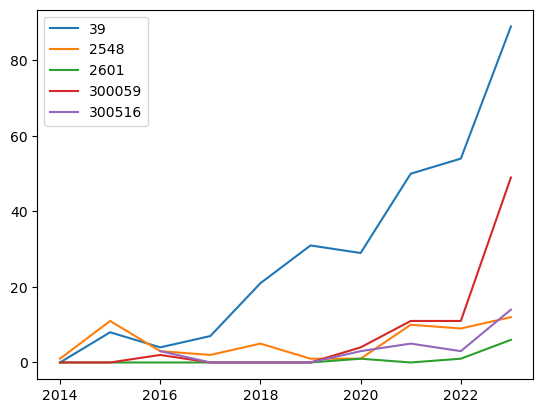

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for code in grouped['code'].unique():
    data = grouped[grouped['code'] == code]
    ax.plot(data['year'], data['keyword_count'], label=code)
ax.legend()
plt.show()